## FRC Team Analysis
#### By Draven Schilling, 10/18/19

The First Robotics competition is a high school level robotics competition where teams across the world are introduced to a new engineering challenge every year and are given 10 weeks to design, build, and test their robots; then in the following weeks are eligible to compete at local, district, and regional competitions. Finally, regional winners and special award winners are invited to attend the FRC championship to play aginst the best of the best and determine who the 'world champions' that year are. 

In this report I will be analyzing team performance over the years to identify correlations in what makes a successful team. The dataset I have acquired was created specifically for this purpose and was obtained by scraping “The Blue Alliance API”. The Blue Alliance is the largest mainstream resource for storing FIRST competition data from each year. From the API I was able to obtain regional, district, and chapionship data for each team each year. This included regional data such as where the competitions was located and the event type; Also I was able to obtain team statistics per competition (wins : losses : ties) and interpreted data such as offensive and defensive power rating. Finally I was able to get measures to classify success such as total number awards a team achieved and number of both regional and championship wins.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import seaborn as sns

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

We first import the required libraries and privew the data to ensure it was loaded correctly and see what we have to work with.

In [2]:
tba_df = pd.read_json("tba-data.txt")
tba_df.head()

,ccwm,city,dpr,event_size,lat,lng,losses,opr,rank,rookie_year,state_prov,team_key,ties,total_team_awards,total_team_blue_banners,total_team_champ_wins,week,wins,year
0,-111.162777,Goodrich,63.384768,3,NaN,NaN,0.0,-65.242301,1,2001.0,Michigan,frc494,0.0,66,13,0,NaN,7.0,2007
1,114.092243,Rockledge,-49.900314,3,NaN,NaN,0.0,85.886224,2,1999.0,Florida,frc233,0.0,92,20,0,NaN,7.0,2007
2,-149.433337,Sparta,73.733529,3,NaN,NaN,1.0,-93.164099,3,2004.0,NJ,frc1302,0.0,8,2,0,NaN,6.0,2007
3,-158.424486,Melbourne,82.621490,3,NaN,NaN,1.0,-93.267287,4,2000.0,Florida,frc386,0.0,26,5,0,NaN,6.0,2007
4,127.135284,Peterborough,-18.267791,3,NaN,NaN,1.0,104.637489,5,2006.0,NH,frc1824,0.0,1,1,0,NaN,6.0,2007


In [3]:
tba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64064 entries, 0 to 64063
Data columns (total 19 columns):
ccwm                       64064 non-null float64
city                       64063 non-null object
dpr                        64064 non-null float64
event_size                 64064 non-null int64
lat                        0 non-null float64
lng                        0 non-null float64
losses                     55628 non-null float64
opr                        64064 non-null float64
rank                       64064 non-null int64
rookie_year                63834 non-null float64
state_prov                 64063 non-null object
team_key                   64064 non-null object
ties                       55628 non-null float64
total_team_awards          64064 non-null int64
total_team_blue_banners    64064 non-null int64
total_team_champ_wins      64064 non-null int64
week                       52832 non-null float64
wins                       55628 non-null float64
year        

### Hypothesis

The goals for examining this data is to classify what metrics "good teams" share in common and ultimatly use those metrics to create a predictive model that determines which teams will be good in the following season (2019).

Firstly, we need to identify which metrics are meaningful in making a team "good". Furthermore, we also need to classify what a good team is. For the purpose of this report we classify how good a team as the number of competitions they attended over the number of wins / (blue banners) they obtained. It only seems logical to engineer this feature first and append it to our data.

Hypothesis:
1. total improvement week to week 
2. offensive power rating > defensive power rating
3. older teams are better
4. locational hotspots of good teams
5. seeding over time
6. districts better or worse?
7. won a championship = more regional wins
8. Average rank vs regional wins
9. whats more powerful an offensive robot or defensive robot?

 
Some initial hypothesizes I have about the data is that there may be regional “hotspots” of good teams such as the Silicon Valley area or the east coast. I also hypothesize that teams with more total awards go to more competitions and generally have higher opr’s (offensive power rating) and ccwm’s (calculated contribution to winning margin). I also predict teams that have any championship wins are consistently better than average teams or that regional winners usually have higher opr’s then dpr’s (defensive power rating)


### Data Visualization
In order to gain a better idea of the predictive power lets plot some of our predictive statistics against the number of wins (blue banners) a team owns.

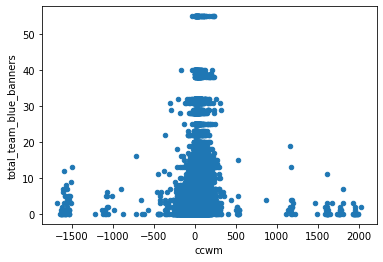

In [12]:
tba_df.plot(x = "ccwm", y = "total_team_blue_banners", kind="scatter")

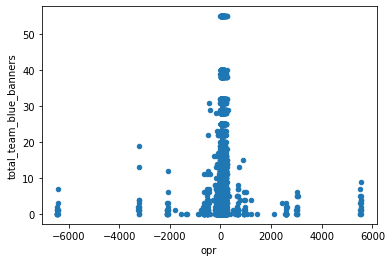

In [13]:
tba_df.plot(x = "opr", y = "total_team_blue_banners", kind="scatter")

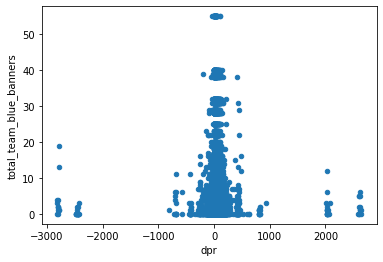

In [14]:
tba_df.plot(x = "dpr", y = "total_team_blue_banners", kind="scatter")

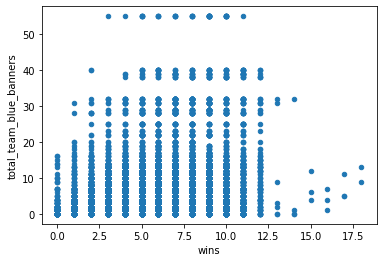

In [15]:
tba_df.plot(x = "wins", y = "total_team_blue_banners", kind="scatter")

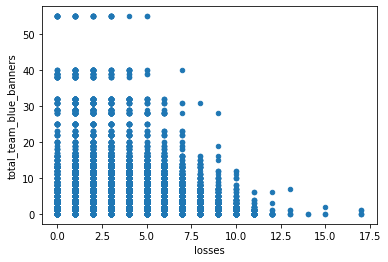

In [16]:
tba_df.plot(x = "losses", y = "total_team_blue_banners", kind="scatter")

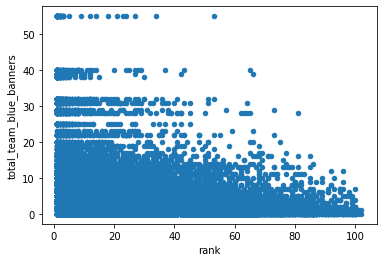

In [17]:
tba_df.plot(x = "rank", y = "total_team_blue_banners", kind="scatter")

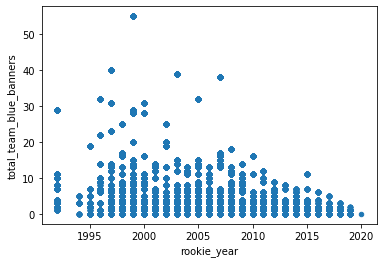

In [18]:
tba_df.plot(x = "rookie_year", y = "total_team_blue_banners", kind="scatter")

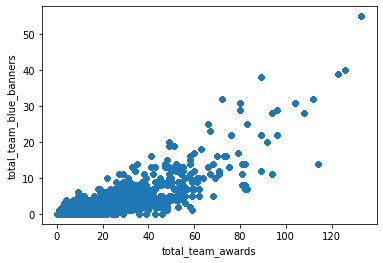

In [19]:
tba_df.plot(x = "total_team_awards", y = "total_team_blue_banners", kind="scatter")

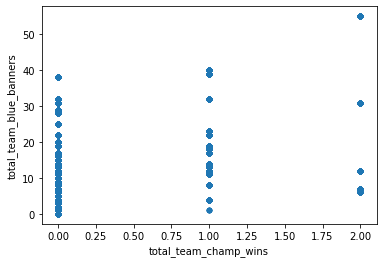

In [20]:
tba_df.plot(x = "total_team_champ_wins", y = "total_team_blue_banners", kind="scatter")

### Data Pre-Processing
The first thing we may want to do is standardize all of the data and get rid of Null row entries. We may also want to convert types where applicable. 
One thing that's initially intresting is that all of the latitude and logitude entries are null. As it turns out, this is a new features TBA is supporting and I guess no teams have bothered to enter their gps coordinates on their global team page so with that in mind, we can likley remove the columns entirely. 

In [5]:
del tba_df['lat']
del tba_df['lng']
tba_df.state_prov = tba_df.state_prov.astype("category")
tba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64064 entries, 0 to 64063
Data columns (total 17 columns):
ccwm                       64064 non-null float64
city                       64063 non-null object
dpr                        64064 non-null float64
event_size                 64064 non-null int64
losses                     55628 non-null float64
opr                        64064 non-null float64
rank                       64064 non-null int64
rookie_year                63834 non-null float64
state_prov                 64063 non-null category
team_key                   64064 non-null object
ties                       55628 non-null float64
total_team_awards          64064 non-null int64
total_team_blue_banners    64064 non-null int64
total_team_champ_wins      64064 non-null int64
week                       52832 non-null float64
wins                       55628 non-null float64
year                       64064 non-null int64
dtypes: category(1), float64(8), int64(6), object(2)
m

Let's next learn how to best impute the rows which have missing values. For wins, losses, and ties we will impute using the mean. For the one row of each state/prov and city, we will remove those two rows. And for the remaining collumns we will plot the distributions of the collums which have missing values in order to determine the best approach for imputation.

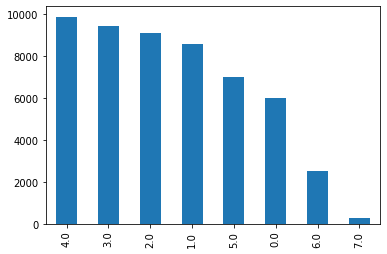

In [6]:
tba_df.dropna(how='any', subset=['city', 'state_prov'], inplace=True)
tba_df['week'].value_counts().plot(kind='bar')

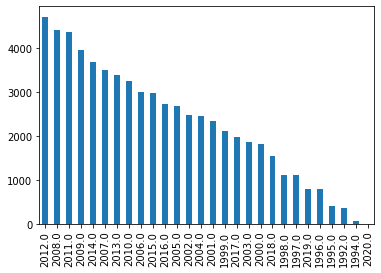

In [7]:
tba_df['rookie_year'].value_counts().plot(kind='bar')

Given the context, I feel the best way to impute week and rookie year is with mode because an average would not make sense and instead it's probobly safest to assume the most common since there is no lexographic relation between weeks and years.
Next, let's breakout our categorical varriable (state_prov) with one hot encoding for later processing and then use our traning data to impute wins, losses, ties, week, and rookie year useing the pre-described imputation methods.

In [8]:
all_columns = ['ccwm', 'dpr', 'opr', 'wins', 'losses', 'ties',
               'year', 'week', 'rank', 'rookie_year' 'state_prov', 
               'total_team_awards', 'total_team_blue_banners', 'total_team_champ_wins']
dummy_columns = {}
dummies = pd.get_dummies(tba_df['state_prov'], prefix='state_prov')
dummy_columns['state_prov'] = dummies.columns.values
tba_df = tba_df.merge(dummies, left_index=True, right_index=True)
tba_df = tba_df.drop(columns='state_prov')

df_train, df_test = train_test_split(tba_df)
print(tba_df.shape[0], df_train.shape[0], df_test.shape[0])

64063 48047 16016


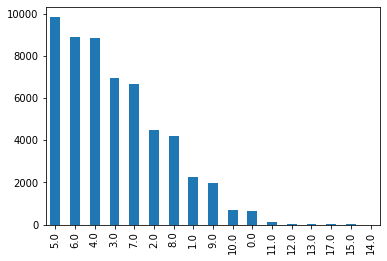

In [9]:
tba_df['losses'].value_counts().plot(kind='bar')

In [10]:
meanImputer = Imputer(missing_values=np.nan)
modeImputer = Imputer(strategy="most_frequent", missing_values=np.nan)
mean_train = meanImputer.fit_transform(df_train[['losses', 'wins', 'ties']])
mean_test = meanImputer.transform(df_test[['losses', 'wins', 'ties']])
mode_train = meanImputer.fit_transform(df_train[['week', 'rookie_year']])
mode_test = meanImputer.transform(df_test[['week', 'rookie_year']])
del df_train['losses']
del df_test['losses']
del df_train['wins']
del df_test['wins']
del df_train['ties']
del df_test['ties']
df_train['losses'] = mean_train['losses']

C:\Users\schillingdl\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\schillingdl\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices